## An ML model learn to perform equalization 

In [1]:
# Import packages from other direction. Itis necessary if the project is structured as:
# my_project
# ├── notebooks
# │   └── Generate Radio Data for tr.ipynb
# ├── local_python_package
# │   ├── __init__.py
# │   ├── models.py
# ├── README.md
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import multiprocessing as mp
import numpy as np

import tensorflow as tf
from radioml.dataset import RadioDataGenerator

# For visualization
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

## Paramters

In [3]:
DATA_LEN = 200
PREAMBLE_LEN = 40
CHANNEL_LEN = 2

SNR_TRAIN = 20.0
OMEGA_TRAIN = 1/50

## Construct data generator

In [4]:
radio = RadioDataGenerator(data_len    =DATA_LEN, 
                           preamble_len=PREAMBLE_LEN, 
                           channels_len=CHANNEL_LEN,
                           modulation_scheme='QPSK')
training_generator = radio.equalization_data_generator(OMEGA_TRAIN, 
                                                       SNR_TRAIN, 
                                                       batch_size=256, 
                                                       num_cpus=8)
validation_generator = radio.equalization_data_generator(OMEGA_TRAIN, 
                                                         SNR_TRAIN, 
                                                         batch_size=256, 
                                                         seed=2018)

In [5]:
# # Visualize a few examples
# examples = next(radio.equalization_data_generator(OMEGA_TRAIN, 
#                                                   SNR_TRAIN, 
#                                                   batch_size=4, 
#                                                   num_cpus=8))
# [preambles,corrected_preamble, corrected_data], equalized_packet = examples
# def visualize(data):
#     a = plt.scatter(data[...,0].flatten(),
#                 data[...,1].flatten())
#     plt.axhline()
#     plt.axvline()
#     return a
    
# a = visualize(corrected_data)
# b = visualize(equalized_packet)

# plt.legend((a, b), ('Before Equalization', 'After Equalization'))

Number of training parameters: 215464


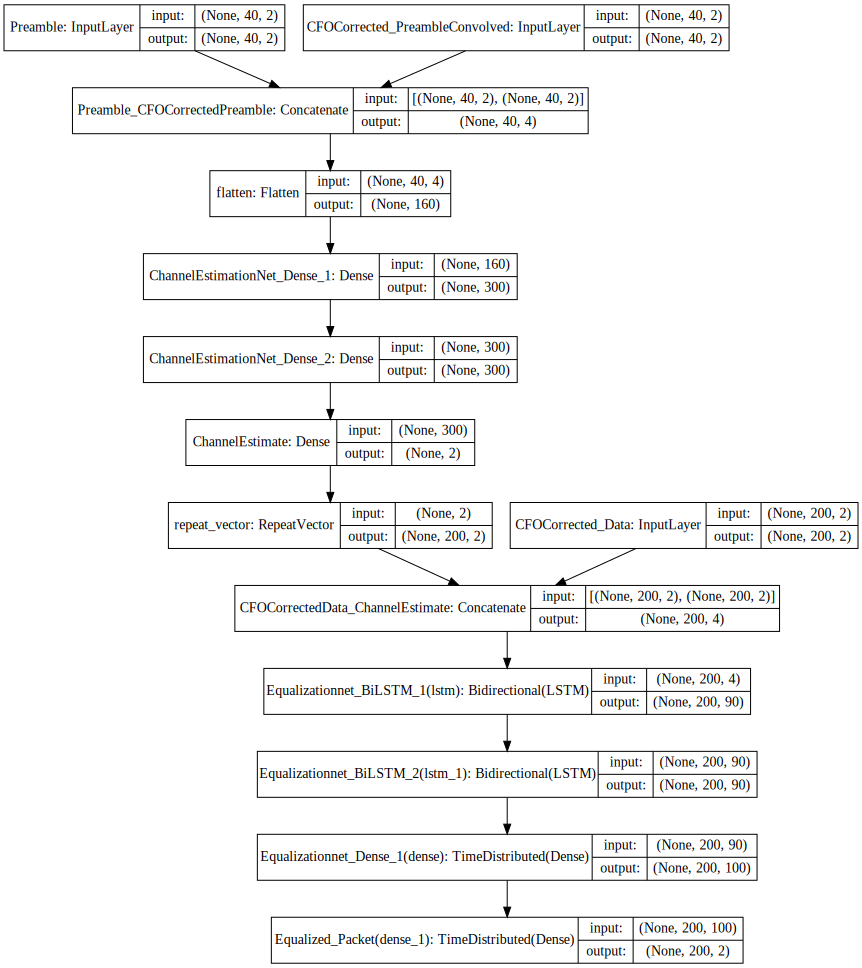

In [6]:
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, TimeDistributed, RepeatVector

tf.keras.backend.clear_session()

def channel_estimation(preamble, cfo_corrected_preamble, scope='ChannelEstimationNet'):
    """Channel Estimation."""
    with tf.name_scope('ChannelEstimationNet'):
        inputs = tf.keras.layers.concatenate([preamble, cfo_corrected_preamble], axis=-1,
                                            name='Preamble_CFOCorrectedPreamble')
        inputs = tf.keras.layers.Flatten()(inputs)
        x = Dense(300, 'relu', name='ChannelEstimationNet_Dense_1')(inputs)
        x = Dense(300, 'relu', name='ChannelEstimationNet_Dense_2')(x)
        x = Dense(CHANNEL_LEN, 'sigmoid', name='ChannelEstimate')(x)
    return x


def equalization_network(cfo_corrected_data, chan_est):
    """Given a [preamble, preambe_conv, data_conv] Predict equalized packet """
    
    chan_est = RepeatVector(DATA_LEN)(chan_est)
    inputs = tf.keras.layers.concatenate([cfo_corrected_data, chan_est], axis=-1,
                                        name="CFOCorrectedData_ChannelEstimate")
    with tf.name_scope('EqualizationNet'):
        scope='Equalizationnet'
        x = Bidirectional(LSTM(45, return_sequences=True), 
                          name=scope+'_BiLSTM_1')(inputs)
        x = Bidirectional(LSTM(45, return_sequences=True), 
                          name=scope+'_BiLSTM_2')(x)
        x = TimeDistributed(Dense(100, activation='relu'), 
                            name=scope+'_Dense_1')(x)
    x = TimeDistributed(Dense(2, activation='linear'), 
                        name='Equalized_Packet')(x)
    return x


# Think of keras.Input as tf.placeholder
preamble               = tf.keras.layers.Input(shape=(PREAMBLE_LEN, 2), name='Preamble')
cfo_corrected_data     = tf.keras.layers.Input(shape=(DATA_LEN, 2), name='CFOCorrected_Data')
cfo_corrected_preamble = tf.keras.layers.Input(shape=(PREAMBLE_LEN, 2), name='CFOCorrected_PreambleConvolved')

# Build tensorflow graph
   
channel_est = channel_estimation(preamble, cfo_corrected_preamble)

                  
model = tf.keras.Model(inputs=[preamble, cfo_corrected_preamble], outputs= channel_est)
model.trainable = True             
                  
equalized_packet = equalization_network(cfo_corrected_data, channel_est)

model = tf.keras.Model(inputs=[preamble, cfo_corrected_preamble, cfo_corrected_data], 
                       outputs=equalized_packet)

print("Number of training parameters: %d" % model.count_params())
tf.keras.utils.plot_model(model, "equalization.svg", show_shapes=True, show_layer_names=True)
SVG("equalization.svg")

In [7]:
model.compile('adam','mse')
model.load_weights('../models/equalization4.hdf5')
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=200,
    validation_steps=10,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('../models/equalization4.hdf5', save_best_only=True)],
    epochs=50)

Epoch 1/50
200/200 [==============================] - 201s 1s/step - loss: 0.0103 - val_loss: 0.0101
Epoch 2/50
200/200 [==============================] - 193s 967ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 3/50
200/200 [==============================] - 193s 966ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 4/50
200/200 [==============================] - 193s 965ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 5/50
200/200 [==============================] - 193s 966ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 6/50
200/200 [==============================] - 193s 967ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 7/50
200/200 [==============================] - 193s 966ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 8/50
200/200 [==============================] - 193s 967ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 9/50
200/200 [==============================] - 193s 965ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 10/50
200/200 [==============================] - 193s 967ms/s

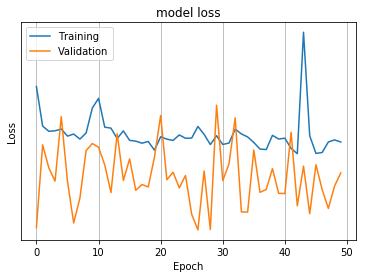

In [8]:
# Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.semilogy()
plt.show()

In [9]:
inputs, labels = next(radio.equalization_data_generator(OMEGA_TRAIN, 
                                                  SNR_TRAIN, 
                                                  batch_size=16, 
                                                  num_cpus=16,
                                                  seed=2020))

predictions = model.predict(inputs)

c = visualize(inputs[-1])
a = visualize(predictions)
b = visualize(labels)

plt.legend((a, b), ('Predictions', 'Labels', 'Inputs'))

NameError: name 'visualize' is not defined